# Fluence Example Notebook

This notebook shows the workings of the forecasting model for electron Fluence across the entirety of the outer Radiation Belt. It can pull pre-trained forests from Zenodo, or will train a Forest within this notebook



In [1]:
#Install all the packages
!pip install wget
!pip install numpy==1.26.0
!pip install matplotlib==3.8.0
!pip install scikit-learn==1.6.1
!pip install tqdm==4.66.1
!pip install joblib==1.3.2
!pip install pandas==2.1.1


In [2]:
# Importing all the required packages
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib
from tqdm import tqdm
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import pandas as pd
import wget

# Importing the Training and Testing Sets
Import the training and testing datasets, these are stored in a zenodo repositary and can be downloaded straight from there.

We use a chronological split to form the training and test sets, with the first $\frac{2}{3}$ forming the training set and the remaining forming the testing set, this gives us a training set from 25/09/12 to 01/07/2017 and a testing set from 02/07/2017 to 16/07/2019

In [11]:
#Pulling the training dataset from zenodo

training_data=pd.read_hdf(wget.download("https://zenodo.org/records/15130352/files/VAMPIRE-E_training_data.h5"))
training_data.head()


,SML_mean_1_delay,SML_mean_3_delay,AL_mean_4_delay,SML_median_5_delay,AL_mean_7_delay,fluence,binary_cluster,epoch
1377,-57.343750,-49.339583,-72.434028,-87.0,-72.746528,9.560375,0,2012-09-25 12:00:00
584,-51.689583,-47.443056,-19.149306,-87.0,-233.968750,9.511689,0,2012-09-26 12:00:00
429,-85.463889,-57.343750,-18.809028,-45.0,-71.812500,9.430357,0,2012-09-27 12:00:00
443,-41.266667,-51.689583,-18.538194,-49.0,-72.434028,9.408922,0,2012-09-28 12:00:00
996,-37.107639,-85.463889,-18.444444,-56.0,-19.149306,9.381312,0,2012-09-29 12:00:00


In [12]:
#Pulling the test dataset from zenodo
testing_data=pd.read_hdf(wget.download("https://zenodo.org/records/15130352/files/VAMPIRE-E_testing_data.h5"))
testing_data.head()

,SML_mean_1_delay,SML_mean_3_delay,AL_mean_4_delay,SML_median_5_delay,AL_mean_7_delay,fluence,binary_cluster,epoch
422,-186.013194,-40.166667,-57.569444,-67.0,-99.583333,9.349887,0,2017-07-02 12:00:00
548,-80.320833,-114.626389,-28.010417,-37.0,-67.510417,9.273192,0,2017-07-03 12:00:00
554,-71.009028,-186.013194,-86.239583,-30.0,-66.989583,9.248217,0,2017-07-04 12:00:00
107,-67.020139,-80.320833,-150.416667,-60.0,-57.569444,9.276142,0,2017-07-05 12:00:00
267,-61.015972,-71.009028,-45.284722,-139.0,-28.010417,9.127012,0,2017-07-06 12:00:00


# Training the Forests

The following 3 cells are used to train the model, the first and either the second or third should be run

The first defines the model input for each forecasting window

The second trains the random forests from scratch

The third imports pre-trained models from the Zenodo repository

In [13]:
#Defining the model inputs for each forecasting window

model_inputs=[
    #Nowcasting
    ['SML_mean_1_delay', 'SML_mean_3_delay', 'AL_mean_4_delay',  'SML_median_5_delay',  'AL_mean_7_delay'],
    # 1-day lead time
    ['SML_mean_3_delay', 'AL_mean_4_delay',  'SML_median_5_delay',  'AL_mean_7_delay'],
    # 2-day lead time
    ['SML_mean_3_delay', 'AL_mean_4_delay',  'SML_median_5_delay',  'AL_mean_7_delay'],
    # 3-day lead time
    ['AL_mean_4_delay',  'SML_median_5_delay',  'AL_mean_7_delay'],
    # 4-day lead time
    ['SML_median_5_delay',  'AL_mean_7_delay'],
    # 5-day lead time
    ['AL_mean_7_delay'],
    # 6-day lead time
    ['AL_mean_7_delay']
    ]


In [ ]:
# Training Forests from scratch

lead_time_0_days_forest=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[model_inputs[0]],training_data['binary_cluster'])
lead_time_1_days_forest=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[model_inputs[1]],training_data['binary_cluster'])
lead_time_2_days_forest=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[model_inputs[2]],training_data['binary_cluster'])
lead_time_3_days_forest=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[model_inputs[3]],training_data['binary_cluster'])
lead_time_4_days_forest=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[model_inputs[4]],training_data['binary_cluster'])
lead_time_5_days_forest=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[model_inputs[5]],training_data['binary_cluster'])
lead_time_6_days_forest=RandomForestClassifier(n_estimators=50,min_samples_leaf=100,max_depth=8,class_weight='balanced',bootstrap=False,max_features=None,random_state=5,criterion='gini').fit(training_data[model_inputs[6]],training_data['binary_cluster'])

In [14]:
#Importing pre-trained forests


lead_time_0_days_forest=joblib.load(wget.download("https://zenodo.org/records/15130352/files/VAMPIRE-E_0_day_leadtime_pretrained_forest.joblib"))
lead_time_1_days_forest=joblib.load(wget.download("https://zenodo.org/records/15130352/files/VAMPIRE-E_1_day_leadtime_pretrained_forest.joblib"))
lead_time_2_days_forest=joblib.load(wget.download("https://zenodo.org/records/15130352/files/VAMPIRE-E_2_day_leadtime_pretrained_forest.joblib"))
lead_time_3_days_forest=joblib.load(wget.download("https://zenodo.org/records/15130352/files/VAMPIRE-E_3_day_leadtime_pretrained_forest.joblib"))
lead_time_4_days_forest=joblib.load(wget.download("https://zenodo.org/records/15130352/files/VAMPIRE-E_4_day_leadtime_pretrained_forest.joblib"))
lead_time_5_days_forest=joblib.load(wget.download("https://zenodo.org/records/15130352/files/VAMPIRE-E_5_day_leadtime_pretrained_forest.joblib"))
lead_time_6_days_forest=joblib.load(wget.download("https://zenodo.org/records/15130352/files/VAMPIRE-E_6_day_leadtime_pretrained_forest.joblib"))


# Testing the Forests

Now we have the trained forests we can test them on any given period, with the next three cells allowing you to select the desired period to look at, a confusion matrix and performance statistics for each forecasting leadtime are then calculated, and the final cell allows you to produce daily forecast plots (This will create a panel on the plot for each day so may not be useful for long assessment periods)

In [15]:
#Select the assessment period
#Start and End should be edited to the desired start and end dates in the form YYYY-MM-DD
#The earliest start date should be 2017-07-02

Start= '2017-07-02'

#The latest end date should be 2019-07-16

End='2019-07-16'


#We now pull the desired portions of the testing set

start_index=np.where( testing_data['epoch']==Start+' 12:00:00')[0][0]
end_index=np.where( testing_data['epoch']==End+' 12:00:00')[0][0]+7

selected_testing_data=testing_data.iloc[start_index:end_index]
selected_testing_data.head()

selected_testing_data.head(n=20)

,SML_mean_1_delay,SML_mean_3_delay,AL_mean_4_delay,SML_median_5_delay,AL_mean_7_delay,fluence,binary_cluster,epoch
422,-186.013194,-40.166667,-57.569444,-67.0,-99.583333,9.349887,0,2017-07-02 12:00:00
548,-80.320833,-114.626389,-28.010417,-37.0,-67.510417,9.273192,0,2017-07-03 12:00:00
554,-71.009028,-186.013194,-86.239583,-30.0,-66.989583,9.248217,0,2017-07-04 12:00:00
107,-67.020139,-80.320833,-150.416667,-60.0,-57.569444,9.276142,0,2017-07-05 12:00:00
267,-61.015972,-71.009028,-45.284722,-139.0,-28.010417,9.127012,0,2017-07-06 12:00:00
710,-107.981250,-67.020139,-49.052083,-70.0,-86.239583,9.101942,0,2017-07-07 12:00:00
412,-69.596528,-61.015972,-52.128472,-55.0,-150.416667,9.034473,0,2017-07-08 12:00:00
137,-137.188194,-107.981250,-36.253472,-58.0,-45.284722,8.887976,0,2017-07-09 12:00:00
739,-190.786806,-69.596528,-89.652778,-46.0,-49.052083,9.394162,0,2017-07-10 12:00:00
384,-102.175000,-137.188194,-49.461806,-84.0,-52.128472,9.510638,0,2017-07-11 12:00:00


In [16]:
#Predicting the Test Window, and calculating the metrics
precision_list=[]
balanced_accuracy_list=[]
f1_score_list=[]
recall_list=[]
tnr_list=[]
tpr_list=[]


# Nowcast
leadtime_0_days_prediction=lead_time_0_days_forest.predict(selected_testing_data[model_inputs[0]])
leadtime_0_days_probabilities=lead_time_0_days_forest.predict_proba(selected_testing_data[model_inputs[0]])

leadtime_0_days_precision=precision_score(selected_testing_data['binary_cluster'], leadtime_0_days_prediction)
leadtime_0_days_recall=recall_score(selected_testing_data['binary_cluster'], leadtime_0_days_prediction)
leadtime_0_days_f1=f1_score(selected_testing_data['binary_cluster'], leadtime_0_days_prediction)
leadtime_0_days_balanced_accuracy=balanced_accuracy_score(selected_testing_data['binary_cluster'],leadtime_0_days_prediction)
leadtime_0_days_cm=confusion_matrix(selected_testing_data['binary_cluster'],leadtime_0_days_prediction,normalize='true')
leadtime_0_days_true_negative_rate=leadtime_0_days_cm[0,0]
leadtime_0_days_true_positive_rate=leadtime_0_days_cm[1,1]

precision_list.append(leadtime_0_days_precision)
balanced_accuracy_list.append(leadtime_0_days_balanced_accuracy)
f1_score_list.append(leadtime_0_days_f1)
recall_list.append(leadtime_0_days_recall)
tnr_list.append(leadtime_0_days_true_negative_rate)
tpr_list.append(leadtime_0_days_true_positive_rate)


# 1-day lead time
leadtime_1_days_prediction=lead_time_1_days_forest.predict(selected_testing_data[model_inputs[1]])
leadtime_1_days_probabilities=lead_time_1_days_forest.predict_proba(selected_testing_data[model_inputs[1]])

leadtime_1_days_precision=precision_score(selected_testing_data['binary_cluster'], leadtime_1_days_prediction)
leadtime_1_days_recall=recall_score(selected_testing_data['binary_cluster'], leadtime_1_days_prediction)
leadtime_1_days_f1=f1_score(selected_testing_data['binary_cluster'], leadtime_1_days_prediction)
leadtime_1_days_balanced_accuracy=balanced_accuracy_score(selected_testing_data['binary_cluster'],leadtime_1_days_prediction)
leadtime_1_days_cm=confusion_matrix(selected_testing_data['binary_cluster'],leadtime_1_days_prediction,normalize='true')
leadtime_1_days_true_negative_rate=leadtime_1_days_cm[0,0]
leadtime_1_days_true_positive_rate=leadtime_1_days_cm[1,1]

precision_list.append(leadtime_1_days_precision)
balanced_accuracy_list.append(leadtime_1_days_balanced_accuracy)
f1_score_list.append(leadtime_1_days_f1)
recall_list.append(leadtime_1_days_recall)
tnr_list.append(leadtime_1_days_true_negative_rate)
tpr_list.append(leadtime_1_days_true_positive_rate)

# 2-day lead time
leadtime_2_days_prediction=lead_time_2_days_forest.predict(selected_testing_data[model_inputs[2]])
leadtime_2_days_probabilities=lead_time_2_days_forest.predict_proba(selected_testing_data[model_inputs[2]])

leadtime_2_days_precision=precision_score(selected_testing_data['binary_cluster'], leadtime_2_days_prediction)
leadtime_2_days_recall=recall_score(selected_testing_data['binary_cluster'], leadtime_2_days_prediction)
leadtime_2_days_f1=f1_score(selected_testing_data['binary_cluster'], leadtime_2_days_prediction)
leadtime_2_days_balanced_accuracy=balanced_accuracy_score(selected_testing_data['binary_cluster'],leadtime_2_days_prediction)
leadtime_2_days_cm=confusion_matrix(selected_testing_data['binary_cluster'],leadtime_2_days_prediction,normalize='true')
leadtime_2_days_true_negative_rate=leadtime_2_days_cm[0,0]
leadtime_2_days_true_positive_rate=leadtime_2_days_cm[1,1]

precision_list.append(leadtime_2_days_precision)
balanced_accuracy_list.append(leadtime_2_days_balanced_accuracy)
f1_score_list.append(leadtime_2_days_f1)
recall_list.append(leadtime_2_days_recall)
tnr_list.append(leadtime_2_days_true_negative_rate)
tpr_list.append(leadtime_2_days_true_positive_rate)

# 3-day lead time
leadtime_3_days_prediction=lead_time_3_days_forest.predict(selected_testing_data[model_inputs[3]])
leadtime_3_days_probabilities=lead_time_3_days_forest.predict_proba(selected_testing_data[model_inputs[3]])

leadtime_3_days_precision=precision_score(selected_testing_data['binary_cluster'], leadtime_3_days_prediction)
leadtime_3_days_recall=recall_score(selected_testing_data['binary_cluster'], leadtime_3_days_prediction)
leadtime_3_days_f1=f1_score(selected_testing_data['binary_cluster'], leadtime_3_days_prediction)
leadtime_3_days_balanced_accuracy=balanced_accuracy_score(selected_testing_data['binary_cluster'],leadtime_3_days_prediction)
leadtime_3_days_cm=confusion_matrix(selected_testing_data['binary_cluster'],leadtime_3_days_prediction,normalize='true')
leadtime_3_days_true_negative_rate=leadtime_3_days_cm[0,0]
leadtime_3_days_true_positive_rate=leadtime_3_days_cm[1,1]

precision_list.append(leadtime_3_days_precision)
balanced_accuracy_list.append(leadtime_3_days_balanced_accuracy)
f1_score_list.append(leadtime_3_days_f1)
recall_list.append(leadtime_3_days_recall)
tnr_list.append(leadtime_3_days_true_negative_rate)
tpr_list.append(leadtime_3_days_true_positive_rate)

# 4-day lead time
leadtime_4_days_prediction=lead_time_4_days_forest.predict(selected_testing_data[model_inputs[4]])
leadtime_4_days_probabilities=lead_time_4_days_forest.predict_proba(selected_testing_data[model_inputs[4]])

leadtime_4_days_precision=precision_score(selected_testing_data['binary_cluster'], leadtime_4_days_prediction)
leadtime_4_days_recall=recall_score(selected_testing_data['binary_cluster'], leadtime_4_days_prediction)
leadtime_4_days_f1=f1_score(selected_testing_data['binary_cluster'], leadtime_4_days_prediction)
leadtime_4_days_balanced_accuracy=balanced_accuracy_score(selected_testing_data['binary_cluster'],leadtime_4_days_prediction)
leadtime_4_days_cm=confusion_matrix(selected_testing_data['binary_cluster'],leadtime_4_days_prediction,normalize='true')
leadtime_4_days_true_negative_rate=leadtime_4_days_cm[0,0]
leadtime_4_days_true_positive_rate=leadtime_4_days_cm[1,1]

precision_list.append(leadtime_4_days_precision)
balanced_accuracy_list.append(leadtime_4_days_balanced_accuracy)
f1_score_list.append(leadtime_4_days_f1)
recall_list.append(leadtime_4_days_recall)
tnr_list.append(leadtime_4_days_true_negative_rate)
tpr_list.append(leadtime_4_days_true_positive_rate)

# 5-day lead time
leadtime_5_days_prediction=lead_time_5_days_forest.predict(selected_testing_data[model_inputs[5]])
leadtime_5_days_probabilities=lead_time_5_days_forest.predict_proba(selected_testing_data[model_inputs[5]])

leadtime_5_days_precision=precision_score(selected_testing_data['binary_cluster'], leadtime_5_days_prediction)
leadtime_5_days_recall=recall_score(selected_testing_data['binary_cluster'], leadtime_5_days_prediction)
leadtime_5_days_f1=f1_score(selected_testing_data['binary_cluster'], leadtime_5_days_prediction)
leadtime_5_days_balanced_accuracy=balanced_accuracy_score(selected_testing_data['binary_cluster'],leadtime_5_days_prediction)
leadtime_5_days_cm=confusion_matrix(selected_testing_data['binary_cluster'],leadtime_5_days_prediction,normalize='true')
leadtime_5_days_true_negative_rate=leadtime_5_days_cm[0,0]
leadtime_5_days_true_positive_rate=leadtime_5_days_cm[1,1]

precision_list.append(leadtime_5_days_precision)
balanced_accuracy_list.append(leadtime_5_days_balanced_accuracy)
f1_score_list.append(leadtime_5_days_f1)
recall_list.append(leadtime_5_days_recall)
tnr_list.append(leadtime_5_days_true_negative_rate)
tpr_list.append(leadtime_5_days_true_positive_rate)

# 6-day lead time
leadtime_6_days_prediction=lead_time_6_days_forest.predict(selected_testing_data[model_inputs[6]])
leadtime_6_days_probabilities=lead_time_6_days_forest.predict_proba(selected_testing_data[model_inputs[6]])

leadtime_6_days_precision=precision_score(selected_testing_data['binary_cluster'], leadtime_6_days_prediction)
leadtime_6_days_recall=recall_score(selected_testing_data['binary_cluster'], leadtime_6_days_prediction)
leadtime_6_days_f1=f1_score(selected_testing_data['binary_cluster'], leadtime_6_days_prediction)
leadtime_6_days_balanced_accuracy=balanced_accuracy_score(selected_testing_data['binary_cluster'],leadtime_6_days_prediction)
leadtime_6_days_cm=confusion_matrix(selected_testing_data['binary_cluster'],leadtime_6_days_prediction,normalize='true')
leadtime_6_days_true_negative_rate=leadtime_6_days_cm[0,0]
leadtime_6_days_true_positive_rate=leadtime_6_days_cm[1,1]

precision_list.append(leadtime_6_days_precision)
balanced_accuracy_list.append(leadtime_6_days_balanced_accuracy)
f1_score_list.append(leadtime_6_days_f1)
recall_list.append(leadtime_6_days_recall)
tnr_list.append(leadtime_6_days_true_negative_rate)
tpr_list.append(leadtime_6_days_true_positive_rate)



Number of days above threshold= 260
Number of days below threshold= 485
######## Nowcasting ########
Balanced Accuracy = 0.8095559080095163
F1 Score = 0.7490909090909091
Precision = 0.7103448275862069
Recall = 0.7923076923076923
True Positive Rate= 0.7923076923076923
True Negative Rate= 0.8268041237113402


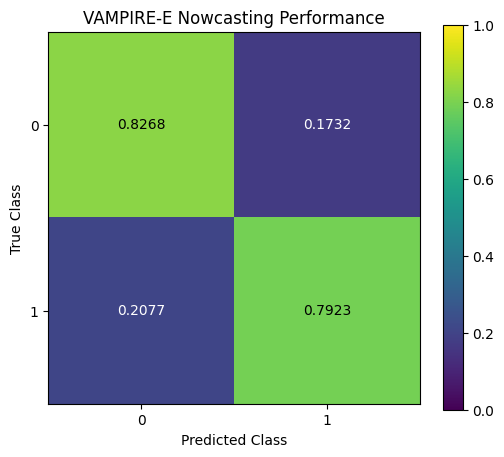

 
 
#####  1-Day Lead Time #####
Balanced Accuracy = 0.7500198255352895
F1 Score = 0.6733870967741935
Precision = 0.7076271186440678
Recall = 0.6423076923076924
True Positive Rate= 0.6423076923076924
True Negative Rate= 0.8577319587628865


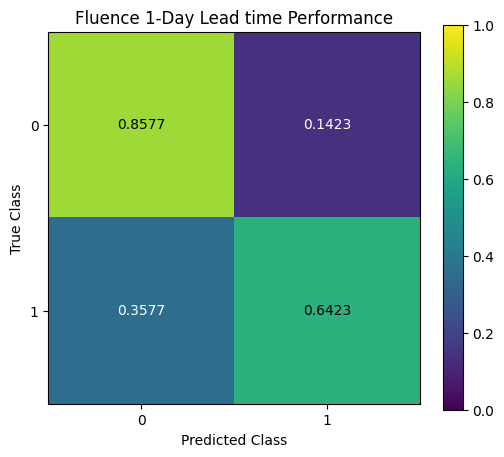

 
 
#####  2-Day Lead Time #####
Balanced Accuracy = 0.7500198255352895
F1 Score = 0.6733870967741935
Precision = 0.7076271186440678
Recall = 0.6423076923076924
True Positive Rate= 0.6423076923076924
True Negative Rate= 0.8577319587628865


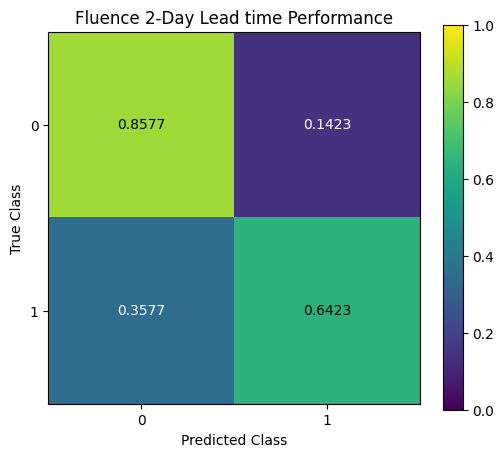

 
 
#####  3-Day Lead Time #####
Balanced Accuracy = 0.718695479777954
F1 Score = 0.6300813008130082
Precision = 0.6681034482758621
Recall = 0.5961538461538461
True Positive Rate= 0.5961538461538461
True Negative Rate= 0.8412371134020619


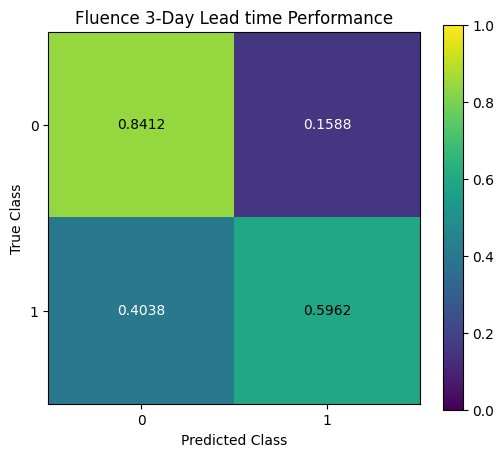

 
 
#####  4-Day Lead Time #####
Balanced Accuracy = 0.6660983346550357
F1 Score = 0.540045766590389
Precision = 0.6666666666666666
Recall = 0.45384615384615384
True Positive Rate= 0.45384615384615384
True Negative Rate= 0.8783505154639175


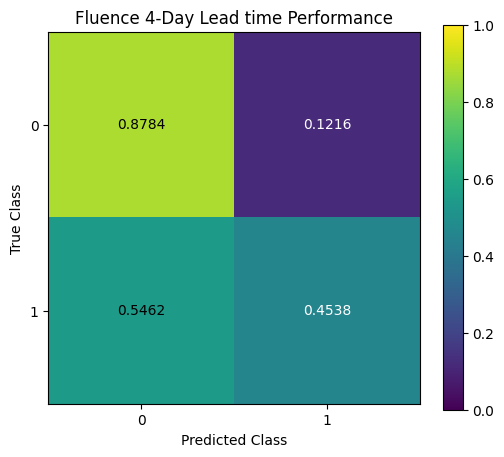

 
 
#####  5-Day Lead Time #####
Balanced Accuracy = 0.6041038858049167
F1 Score = 0.476
Precision = 0.49583333333333335
Recall = 0.4576923076923077
True Positive Rate= 0.4576923076923077
True Negative Rate= 0.7505154639175258


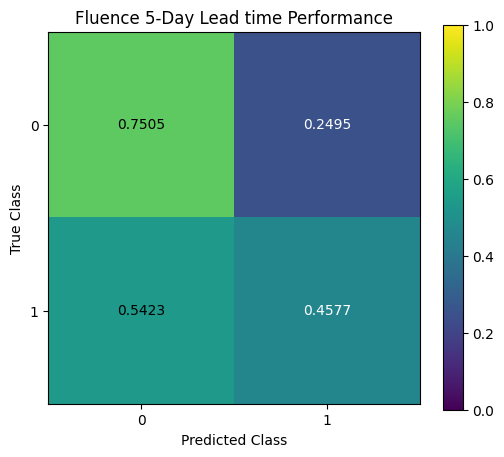

 
 
#####  6-Day Lead Time #####
Balanced Accuracy = 0.6041038858049167
F1 Score = 0.476
Precision = 0.49583333333333335
Recall = 0.4576923076923077
True Positive Rate= 0.4576923076923077
True Negative Rate= 0.7505154639175258


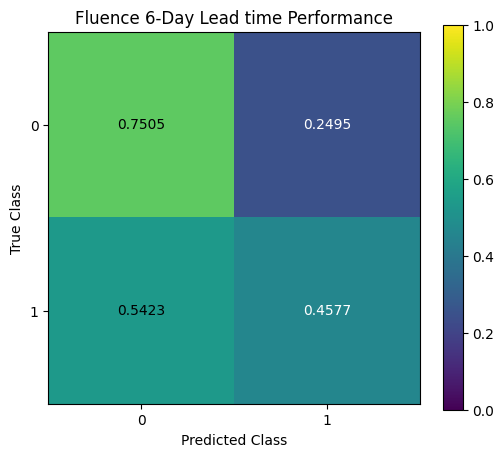

In [17]:
#Plotting the Confusion Matrices and printing the metrics
ticks=[0,1]
labels=['0','1']
counts_0=Counter(selected_testing_data['binary_cluster'])[0]
counts_1=Counter(selected_testing_data['binary_cluster'])[1]

print('Number of days above threshold=',counts_1)
print('Number of days below threshold=',counts_0)

print('######## Nowcasting ########')
print('Balanced Accuracy =', leadtime_0_days_balanced_accuracy)
print('F1 Score =', leadtime_0_days_f1)
print('Precision =', leadtime_0_days_precision)
print('Recall =', leadtime_0_days_recall)
print('True Positive Rate=',leadtime_0_days_true_positive_rate)
print('True Negative Rate=',leadtime_0_days_true_negative_rate)

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6,5))

im=ax.imshow(leadtime_0_days_cm,vmin=0,vmax=1)

ax.set_ylabel('True')
for i in range(0,2):
    for j in range(0,2):
        if leadtime_0_days_cm[i,j]<0.5:
            ax.text(j,i,str('%.4f'%leadtime_0_days_cm[i,j]),color='white',horizontalalignment='center',verticalalignment='center')
        else:
            ax.text(j,i,str('%.4f'%leadtime_0_days_cm[i,j]),horizontalalignment='center',verticalalignment='center')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Fluence Nowcasting Performance')
ax.set_xticks(ticks=ticks,labels=labels)
ax.set_yticks(ticks=ticks,labels=labels)
fig.colorbar(im)
plt.show()
plt.close()


print(' ')
print(' ')
print('#####  1-Day Lead Time #####')
print('Balanced Accuracy =', leadtime_1_days_balanced_accuracy)
print('F1 Score =', leadtime_1_days_f1)
print('Precision =', leadtime_1_days_precision)
print('Recall =', leadtime_1_days_recall)
print('True Positive Rate=',leadtime_1_days_true_positive_rate)
print('True Negative Rate=',leadtime_1_days_true_negative_rate)

cm=leadtime_1_days_cm
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6,5))
im=ax.imshow(cm,vmin=0,vmax=1)
ax.set_ylabel('True')
for i in range(0,2):
    for j in range(0,2):
        if cm[i,j]<0.5:
            ax.text(j,i,str('%.4f'%cm[i,j]),color='white',horizontalalignment='center',verticalalignment='center')
        else:
            ax.text(j,i,str('%.4f'%cm[i,j]),horizontalalignment='center',verticalalignment='center')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Fluence 1-Day Lead time Performance')
ax.set_xticks(ticks=ticks,labels=labels)
ax.set_yticks(ticks=ticks,labels=labels)
fig.colorbar(im)
plt.show()
plt.close()


print(' ')
print(' ')
print('#####  2-Day Lead Time #####')
print('Balanced Accuracy =', leadtime_2_days_balanced_accuracy)
print('F1 Score =', leadtime_2_days_f1)
print('Precision =', leadtime_2_days_precision)
print('Recall =', leadtime_2_days_recall)
print('True Positive Rate=',leadtime_2_days_true_positive_rate)
print('True Negative Rate=',leadtime_2_days_true_negative_rate)

cm=leadtime_2_days_cm
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6,5))
im=ax.imshow(cm,vmin=0,vmax=1)
ax.set_ylabel('True')
for i in range(0,2):
    for j in range(0,2):
        if cm[i,j]<0.5:
            ax.text(j,i,str('%.4f'%cm[i,j]),color='white',horizontalalignment='center',verticalalignment='center')
        else:
            ax.text(j,i,str('%.4f'%cm[i,j]),horizontalalignment='center',verticalalignment='center')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Fluence 2-Day Lead time Performance')
ax.set_xticks(ticks=ticks,labels=labels)
ax.set_yticks(ticks=ticks,labels=labels)
fig.colorbar(im)
plt.show()
plt.close()

print(' ')
print(' ')


print('#####  3-Day Lead Time #####')
print('Balanced Accuracy =', leadtime_3_days_balanced_accuracy)
print('F1 Score =', leadtime_3_days_f1)
print('Precision =', leadtime_3_days_precision)
print('Recall =', leadtime_3_days_recall)
print('True Positive Rate=',leadtime_3_days_true_positive_rate)
print('True Negative Rate=',leadtime_3_days_true_negative_rate)

cm=leadtime_3_days_cm
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6,5))

im=ax.imshow(cm,vmin=0,vmax=1)
ax.set_ylabel('True')
for i in range(0,2):
    for j in range(0,2):
        if cm[i,j]<0.5:
            ax.text(j,i,str('%.4f'%cm[i,j]),color='white',horizontalalignment='center',verticalalignment='center')
        else:
            ax.text(j,i,str('%.4f'%cm[i,j]),horizontalalignment='center',verticalalignment='center')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Fluence 3-Day Lead time Performance')
ax.set_xticks(ticks=ticks,labels=labels)
ax.set_yticks(ticks=ticks,labels=labels)
fig.colorbar(im)
plt.show()
plt.close()


print(' ')
print(' ')
print('#####  4-Day Lead Time #####')
print('Balanced Accuracy =', leadtime_4_days_balanced_accuracy)
print('F1 Score =', leadtime_4_days_f1)
print('Precision =', leadtime_4_days_precision)
print('Recall =', leadtime_4_days_recall)
print('True Positive Rate=',leadtime_4_days_true_positive_rate)
print('True Negative Rate=',leadtime_4_days_true_negative_rate)

cm=leadtime_4_days_cm
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6,5))
im=ax.imshow(cm,vmin=0,vmax=1)
ax.set_ylabel('True')
for i in range(0,2):
    for j in range(0,2):
        if cm[i,j]<0.5:
            ax.text(j,i,str('%.4f'%cm[i,j]),color='white',horizontalalignment='center',verticalalignment='center')
        else:
            ax.text(j,i,str('%.4f'%cm[i,j]),horizontalalignment='center',verticalalignment='center')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Fluence 4-Day Lead time Performance')
ax.set_xticks(ticks=ticks,labels=labels)
ax.set_yticks(ticks=ticks,labels=labels)
fig.colorbar(im)
plt.show()
plt.close()


print(' ')
print(' ')
print('#####  5-Day Lead Time #####')
print('Balanced Accuracy =', leadtime_5_days_balanced_accuracy)
print('F1 Score =', leadtime_5_days_f1)
print('Precision =', leadtime_5_days_precision)
print('Recall =', leadtime_5_days_recall)
print('True Positive Rate=',leadtime_5_days_true_positive_rate)
print('True Negative Rate=',leadtime_5_days_true_negative_rate)

cm=leadtime_5_days_cm
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6,5))
im=ax.imshow(cm,vmin=0,vmax=1)
ax.set_ylabel('True')
for i in range(0,2):
    for j in range(0,2):
        if cm[i,j]<0.5:
            ax.text(j,i,str('%.4f'%cm[i,j]),color='white',horizontalalignment='center',verticalalignment='center')
        else:
            ax.text(j,i,str('%.4f'%cm[i,j]),horizontalalignment='center',verticalalignment='center')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Fluence 5-Day Lead time Performance')
ax.set_xticks(ticks=ticks,labels=labels)
ax.set_yticks(ticks=ticks,labels=labels)
fig.colorbar(im)
plt.show()
plt.close()


print(' ')
print(' ')
print('#####  6-Day Lead Time #####')
print('Balanced Accuracy =', leadtime_6_days_balanced_accuracy)
print('F1 Score =', leadtime_6_days_f1)
print('Precision =', leadtime_6_days_precision)
print('Recall =', leadtime_6_days_recall)
print('True Positive Rate=',leadtime_6_days_true_positive_rate)
print('True Negative Rate=',leadtime_6_days_true_negative_rate)

cm=leadtime_6_days_cm
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6,5))
im=ax.imshow(cm,vmin=0,vmax=1)
ax.set_ylabel('True')
for i in range(0,2):
    for j in range(0,2):
        if cm[i,j]<0.5:
            ax.text(j,i,str('%.4f'%cm[i,j]),color='white',horizontalalignment='center',verticalalignment='center')
        else:
            ax.text(j,i,str('%.4f'%cm[i,j]),horizontalalignment='center',verticalalignment='center')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Fluence 6-Day Lead time Performance')
ax.set_xticks(ticks=ticks,labels=labels)
ax.set_yticks(ticks=ticks,labels=labels)
fig.colorbar(im)
plt.show()
plt.close()


In [ ]:
#A 6-panel plot where each panel shows the model performance by a different metric,

metrics=[balanced_accuracy_list,f1_score_list,precision_list,recall_list,tnr_list,tpr_list]
labels=['Balanced Accuracy', 'F1-Score', 'Precision', 'Recall', 'True Negative Rate', 'True Positivie Rate']
leadtimes=[0,1,2,3,4,5,6]

data_plots=len(metrics) #can be changed to the desired number of panels must be larger than number of columns , currently set to the number of metrics
max_col=3 # the desired number of columns, must be less than data_plots
full=False # used to mark whether each subplot will have a plot, start with it as false, if it remains false
           # if it remains false theres a little code to fill in 1 more panel



if data_plots%max_col ==0: #will there be any remaining panels if not set full as true,
                      #data_plots is the number of data rows/plots
    full=True

if full==True: #if its a full grid then the number of rows is xbins/no of columns
    rows=int(data_plots/max_col)
    fig,axs=plt.subplots(nrows=rows,ncols=max_col,figsize=(4*max_col,3*rows),sharex=True)
else: #if it is not a full grid, we need an extra row
    rows=int(data_plots/max_col)+1
    fig,axs=plt.subplots(nrows=rows,ncols=max_col,figsize=(4*max_col,3*rows),sharex=True)
plt.subplots_adjust(hspace=0.25, wspace=0.25)
#set the row and column values to 0
row=0
col=0
annotes=['a)','b)','c)','d)','e)','f)']

for plot in range(0,data_plots): #loop over all the data that needs plotting

    label=labels[plot] # used in the title, but built here for tidyness
    #actually plot the data
    axs[row,col].plot(leadtimes,metrics[plot],color='black',marker='o')
    axs[row,col].set_title(label)
    axs[row,col].grid()
    axs[row,col].set_xlim(-0.5,6.5)
    axs[row,col].set_ylim(0,1.1)
    axs[row,col].set_xlabel(r'')
    axs[row,col].set_ylabel(label)
    axs[row,col].text(-0.25,1.025,annotes[plot])


    #axs[row,col].legend()
    #if we have not reached the final column move to the next one
    if col<max_col-1:
        col=col+1
    else: # if we have reached the final column, move to the first column on a new row
        #axs[row,col].legend(loc='center',bbox_to_anchor=(1.5,0.5))
        row=row+1
        col=0

if full==False: #if there isnt a full grid this fills the next (and most likely final) panel with another plot
    axs[row,col].plot()


#then just make the overall title and save

for i in range(0,max_col):
    axs[row-1,i].set_xlabel(r'Forecast Lead Time (Days)')


fig.suptitle(r'',fontsize=40,y=0.93)
fig.suptitle('The Forecasting Performance of Fluence for '+Start+' to '+End ,y=0.95)
plt.show()
plt.close()







In [ ]:
#Generate a daily forecast plot (this will plot a panel for each day in the selected test window, and of the length of the testing window, so may not be ideal for large windows)
length_of_selected_window=len(selected_testing_data)-6
print('Length Of Selected Window = ',length_of_selected_window)

test_input=selected_testing_data.iloc[0].loc[model_inputs[0]]


Fluence=testing_data.iloc[start_index-3:end_index+7]['Fluence']
Fluence_dates=[]
for i in range(0,length_of_selected_window+16):
  Fluence_dates.append(datetime.strptime(testing_data.iloc[start_index-3+i]['epoch'], '%Y-%m-%d %H:%M:%S')+timedelta(hours=12))




plt.rcParams["figure.figsize"] = (0.75*length_of_selected_window, 4.5*(length_of_selected_window-1))
fig,axs=plt.subplots(ncols=1,nrows=length_of_selected_window)
plt.subplots_adjust(hspace=0.5)


patches=[]
patches.append(mpatches.Patch(facecolor='blue',edgecolor='black',label='True Positive'))
patches.append(mpatches.Patch(facecolor='lightgray',edgecolor='black',label='True Negative'))
patches.append(mpatches.Patch(facecolor='forestgreen',edgecolor='black',label='False Positive'))
patches.append(mpatches.Patch(facecolor='darkred',edgecolor='black',label='False Negative'))
patches.append(Line2D([0],[0],color='black',marker='o',label=r'Log$_{10}$ Max Daily Fluence'))
patches.append(Line2D([0],[0],color='black',linestyle='dashed',label='Threshold'))


for day in tqdm(range(0,length_of_selected_window)):
  probabilities=[]
  predictions=[]
  forecast_date=[]
  truth=[]
  #Nowcasting

  test_input=selected_testing_data.iloc[day+0].loc[model_inputs[0]].to_frame().transpose()

  forecast_date.append(datetime.strptime(selected_testing_data.iloc[day+0]['epoch'], '%Y-%m-%d %H:%M:%S')+timedelta(hours=12))
  forecast=lead_time_0_days_forest.predict(test_input)
  forecast_prob=lead_time_0_days_forest.predict_proba(test_input)
  truth.append(selected_testing_data.iloc[day+0]['binary_cluster'])
  predictions.append(forecast[0])
  probabilities.append(forecast_prob[0])

  #1-Day Forecasts
  test_input=selected_testing_data.iloc[day+1].loc[model_inputs[1]].to_frame().transpose()
  forecast_date.append(datetime.strptime(selected_testing_data.iloc[day+1]['epoch'], '%Y-%m-%d %H:%M:%S')+timedelta(hours=12))
  forecast=lead_time_1_days_forest.predict(test_input)
  forecast_prob=lead_time_1_days_forest.predict_proba(test_input)
  truth.append(selected_testing_data.iloc[day+1]['binary_cluster'])
  predictions.append(forecast[0])
  probabilities.append(forecast_prob[0])

  #2-Day Forecasts
  test_input=selected_testing_data.iloc[day+2].loc[model_inputs[2]].to_frame().transpose()
  forecast_date.append(datetime.strptime(selected_testing_data.iloc[day+2]['epoch'], '%Y-%m-%d %H:%M:%S')+timedelta(hours=12))
  forecast=lead_time_2_days_forest.predict(test_input)
  forecast_prob=lead_time_2_days_forest.predict_proba(test_input)
  truth.append(selected_testing_data.iloc[day+2]['binary_cluster'])
  predictions.append(forecast[0])
  probabilities.append(forecast_prob[0])

  #3-Day Forecasts
  test_input=selected_testing_data.iloc[day+3].loc[model_inputs[3]].to_frame().transpose()
  forecast_date.append(datetime.strptime(selected_testing_data.iloc[day+3]['epoch'], '%Y-%m-%d %H:%M:%S')+timedelta(hours=12))
  forecast=lead_time_3_days_forest.predict(test_input)
  forecast_prob=lead_time_3_days_forest.predict_proba(test_input)
  truth.append(selected_testing_data.iloc[day+3]['binary_cluster'])
  predictions.append(forecast[0])
  probabilities.append(forecast_prob[0])

  #4-Day Forecasts
  test_input=selected_testing_data.iloc[day+4].loc[model_inputs[4]].to_frame().transpose()
  forecast_date.append(datetime.strptime(selected_testing_data.iloc[day+4]['epoch'], '%Y-%m-%d %H:%M:%S')+timedelta(hours=12))
  forecast=lead_time_4_days_forest.predict(test_input)
  forecast_prob=lead_time_4_days_forest.predict_proba(test_input)
  truth.append(selected_testing_data.iloc[day+4]['binary_cluster'])
  predictions.append(forecast[0])
  probabilities.append(forecast_prob[0])

  #5-Day Forecasts
  test_input=selected_testing_data.iloc[day+5].loc[model_inputs[5]].to_frame().transpose()
  forecast_date.append(datetime.strptime(selected_testing_data.iloc[day+5]['epoch'], '%Y-%m-%d %H:%M:%S')+timedelta(hours=12))
  forecast=lead_time_5_days_forest.predict(test_input)
  forecast_prob=lead_time_5_days_forest.predict_proba(test_input)
  truth.append(selected_testing_data.iloc[day+5]['binary_cluster'])
  predictions.append(forecast[0])
  probabilities.append(forecast_prob[0])

  #6-Day Forecasts
  test_input=selected_testing_data.iloc[day+6].loc[model_inputs[6]].to_frame().transpose()
  forecast_date.append(datetime.strptime(selected_testing_data.iloc[day+6]['epoch'], '%Y-%m-%d %H:%M:%S')+timedelta(hours=12))
  forecast=lead_time_6_days_forest.predict(test_input)
  forecast_prob=lead_time_6_days_forest.predict_proba(test_input)
  truth.append(selected_testing_data.iloc[day+6]['binary_cluster'])
  predictions.append(forecast[0])
  probabilities.append(forecast_prob[0])



  #Plotting
  colour=[]
  for i in range(0,len(truth)):
      if truth[i]==True:
          if np.array(probabilities)[:,1][i]<0.5:
              colour.append('darkred')
          else:
              colour.append('blue')
      if truth[i]==False:
          if np.array(probabilities)[:,1][i]<0.5:
              colour.append('lightgray')
          else:
              colour.append('forestgreen')


  ax=axs[day]

  ax.bar(forecast_date,np.array(probabilities)[:,1],width=1,linewidth=2,color=colour,edgecolor='black',align='center')
  #ax.set_xlim(datetime.strptime(testing_data.iloc[start_index-3]['epoch'], '%Y-%m-%d %H:%M:%S'),datetime.strptime(testing_data.iloc[end_index+3]['epoch'], '%Y-%m-%d %H:%M:%S'))
  ax.set_xlim(Fluence_dates[0],Fluence_dates[-4])
  ax.set_ylim(0,1.1)
  ax.set_ylabel('Probability of being\n above threshold')
  ax.set_title('Forecast Made on day commencing '+selected_testing_data.iloc[day+0]['epoch'])
  ax.set_axisbelow(True)
  ax.grid()
  ax.legend(handles=patches,bbox_to_anchor=(1.4,0.85))

  ax1=ax.twinx()
  ax1.plot(Fluence_dates,Fluence,color='black',marker='o')
  ax1.set_ylim(3,8)
  ax1.set_xlabel(r'Log$_{10}$ Daily Maximum 1.8 MeV Fluence')
  ax1.hlines(y=5.86,xmin=Fluence_dates[0],xmax=Fluence_dates[-3],color='black',linestyles='dashed')


fig.suptitle('Forecast Plots For '+Start+' to '+End,y=0.895,fontsize=15)



